### __실시간 도시 데이터 분석을 통한 인사이트 도출__

#### 대상지역: 삼각지
__개요__
* 지하철 역 내의 유동인구의 성별/연령별 변화를 분석하고 그 결과를 적절한 광고 선정 지표 구축에 사용하고자함
* 따라서, 본 분석 보고서는 시범지역인 삼각지의 시간에 따른 성별/연령별 변화를 분석하고 인사이트를 도출함
* 또한, 광고 선정 지표 산정 방법을 시범적으로 제안함

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import urllib.parse
import json

In [2]:
# MySQL 연결 정보 설정
target_loc = 1 #[1:삼각지, 2:군자...]

with open('./SQL_parameter.json') as f:
    par = json.load(f)
host = par['host']
port = par['port']
username = par['username']
password = par['password']
database = par['database']

# 비밀번호 URL 인코딩
encoded_password = urllib.parse.quote_plus(password)

# SQLAlchemy 엔진 생성
engine = create_engine(f"mysql+pymysql://{username}:{encoded_password}@{host}:{port}/{database}")

# SQL 쿼리 작성
query = "SELECT * FROM population"

# 데이터를 pandas DataFrame으로 읽어오기
df = pd.read_sql(query, engine)

# 지역에 따라 데이터셋 분리 (1-> 삼각지, 2->군자)
df_pop = df[df['region_id']==1]

#### __Step 0: 전처리__

__지역 선택__

In [3]:
title = '삼각지'
df_target = df_pop.copy() #df_gunja.copy()
df_target.set_index('datetime', inplace=True)

__필요없는 컬럼 제거__

In [4]:
df_target = df_target.drop(columns = ['region_id','area_congest', 'area_congest_pre_3', 'min_population'])
print(len(df_target))

1355


#### __Step 1: 통계 분석__

In [5]:
df_desc = df_target.describe()
display(df_desc)

,male_rate,female_rate,10gen,20gen,30gen,40gen,50gen,60gen,70gen,max_population
count,1355.000000,1355.000000,1355.000000,1355.000000,1355.000000,1355.000000,1355.000000,1355.000000,1355.000000,1355.000000
mean,52.144502,47.855498,3.399262,18.421476,25.116015,18.191882,15.723838,10.833358,7.619631,2255.719557
std,1.886520,1.886520,0.707263,3.286033,2.783286,1.843134,1.957631,1.223433,1.355202,410.482273
min,46.900000,43.200000,2.000000,13.000000,20.300000,13.200000,10.900000,7.800000,4.600000,1500.000000
25%,50.700000,46.400000,2.900000,15.700000,22.500000,16.600000,14.100000,9.800000,6.400000,2000.000000
50%,52.400000,47.600000,3.300000,17.600000,24.600000,18.700000,16.400000,11.200000,7.800000,2500.000000
75%,53.600000,49.300000,3.700000,21.200000,27.650000,19.700000,17.400000,11.800000,8.700000,2500.000000
max,56.800000,53.100000,7.300000,27.700000,31.200000,21.900000,19.400000,13.600000,10.900000,3500.000000


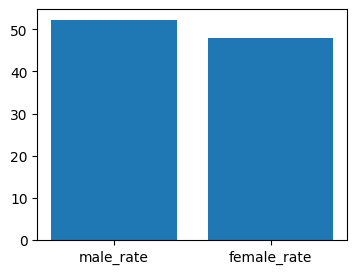

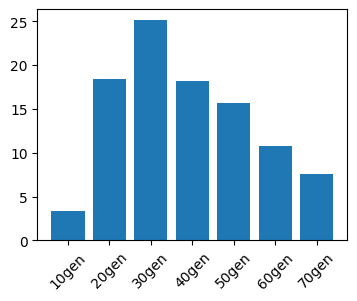

In [6]:
# 평균 성별 분포
target1 = df_desc[['male_rate', 'female_rate']]
plt.figure(figsize=(4,3))
plt.bar(x=['male_rate', 'female_rate'], height=target1.loc['mean'])
plt.show()

# 평균 연령별 분포
target2 = df_desc[['10gen', '20gen', '30gen', '40gen', '50gen', '60gen', '70gen']]
plt.figure(figsize=(4,3))
plt.bar(x=['10gen', '20gen', '30gen', '40gen', '50gen', '60gen', '70gen'], height=target2.loc['mean'])
plt.xticks(rotation=45)
plt.show()

__단순 통계 분석 결과__
* 삼각지에 방문한 인구 대부분은 20대 이상(95%)이였으며, 이 중 20~50대 인원이 약 80%임
  - 즉, __삼각지에 주로 방문하는 인구 대부분은 근로 연령대에 해당함__
  - 따라서, 삼각지에 방문하는 인구의 주 목적은 출근 등 근로를 위해 방문하는것으로 가설을 수립해볼 수 있음
* 남여 방문자 수 차이는 5%정도로 큰 차이를 나타내지 않았음

#### __Step 2: 시계열 분석__
* Min population과 Max popultation는 단순히 500차이이서 같이 분석하는 것이 의미 없음
* __따라서, 이후부터는 Max population 만 분석__

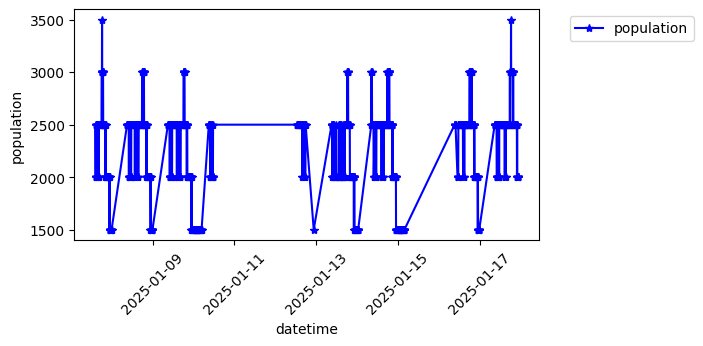

In [7]:
plt.figure(figsize=(6,3))
plt.plot(df_target.index, df_target['max_population'], c='b', marker='*', label='population')
plt.xticks(rotation=45)
plt.xlabel('datetime')
plt.ylabel('population')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

__유동 인구수 시계열 분석 결과__
* 평시 일과 시간(09:00 ~ 18:00)에는 2000명에서 2500명 수준
* 출근 및 퇴근 시간(08:00 ~ 09:00 및 18:00 ~ 19:00)에는 3000명 정도로 급격히 증가하면 peak 값도 해당 시간대에서 나타남
* 지하철 운행이 끝난 후 새벽 시간대에는 1500명을 유지
* __삼각지를 방문하는 사람들의 목적은 주로 근무지 출퇴근이라고 판단할 수 있음__

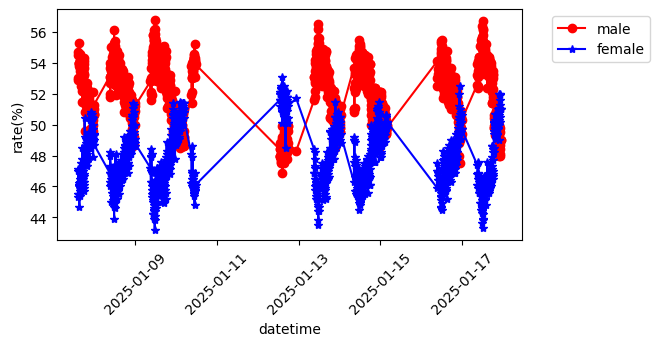

In [8]:
plt.figure(figsize=(6,3))
plt.plot(df_target.index, df_target['male_rate'], c='r', marker='o', label='male')
plt.plot(df_target.index, df_target['female_rate'], c='b', marker='*', label='female')
plt.xticks(rotation=45)
plt.xlabel('datetime')
plt.ylabel('rate(%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

__유동 인구수 시계열 분석 결과__

* 시 일과 시간(09:00 ~ 18:00)에특히 출근 시간(09:00)이후로는 남성이 여성보다 더 많이 방문함
* 일과 시간 이후로 방문자들의 남성은 하락세, 여성은 상승세를 나타내고 있음
* __따라서, 삼각지 주변은 남성 근로자가 많은 시설 등이 위치하고 있는 것으로 예상__ 수 있음

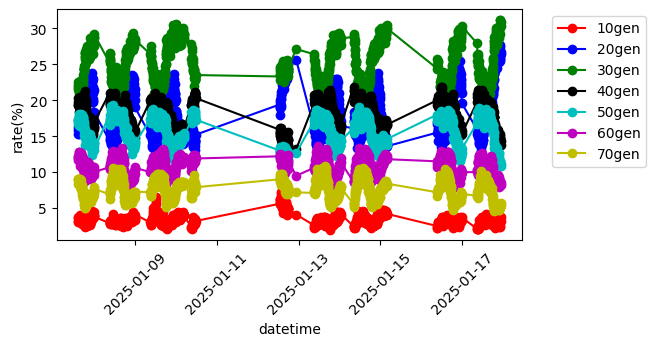

In [9]:
plt.figure(figsize=(6,3))
gen_col = ['10gen', '20gen', '30gen', '40gen', '50gen', '60gen', '70gen']
clr_col = ['r', 'b', 'g', 'k', 'c', 'm', 'y']
for g, c in zip(gen_col, clr_col):
    plt.plot(df_target.index, df_target[g], c=c, marker='o', label=g)
plt.xticks(rotation=45)
plt.xlabel('datetime')
plt.ylabel('rate(%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

__연령 별 방문자수 시계열 분석 결과__
* 30대 그룹은 집계기간 동안 가장 높았으며, 일과 시간 이후 증가하는 추세를 나타냄
* 20대 그룹은 최대-최소의 차이가 가장 높았으며, 일과 시간 이전에는 50대보다 낮았으나, 이후에는 30대 그룹을 제외하고 가장 높음
  - _삼각지 주변에 놀거리(술집)같은거 많았던거 같은데... 원인 중 하나가 될지도?_
* 40대, 50대는 일과시간에는 20대보다 높았으나, 이후에는 20대 비율이 더 높음
  - _20,30들이 선호하는 상권(?)이 삼각지에 분포되어있지 않을까? 조심스럽게 추측해봄_
* 60, 70대는 유사한 패턴은 보이고 있으며, 전체 유동인구에 큰 비율을 차지하지 않음
* 10대는 거의 5%정도
  - _학군이 형성되지 않은거 같음 + 10대는 선호하지 않는 상권 -> 이거 술집 골목 같은거 아녀...ㅋㅋ?_

#### __Step 3: 상관성 분석__

<Axes: >

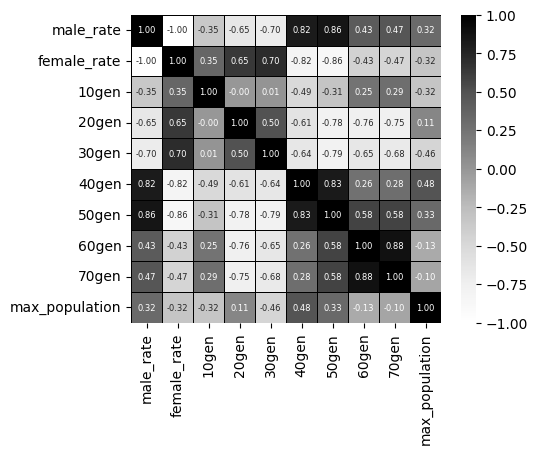

In [10]:
plt.figure(figsize=(5,4))
corr = df_target.corr()
sns.heatmap(corr, vmin=-1, vmax=1, 
            annot=True, annot_kws={'fontsize':6}, fmt='.2f',
            linewidths=0.5, linecolor = 'k', cmap='Greys')

__변수 전체에 대한 상관계수__
* 본 분석 보고서에서는 상관계수가 절대값 0.7 이상인 변수 조합에 대하여 강한 상관 관계를 나타낸다고 정의하겠음
* 남성, 여성 인구 비율은 (당연하게도) 타 변수에 대하여 완벽하게 상반되는 상관계수를 가짐
  - 따라서, 이 후 분석에서는 남성은 xx 변수랑 강한 음의 상관계수를 가지는데 여성은 강한 양의 상관계수를 가지는가 등의 분석은 의미가 없음
* 각 연령들 간 상관계수 분석은 유의미한 해석이 가능한 경우에만 따로 분석 

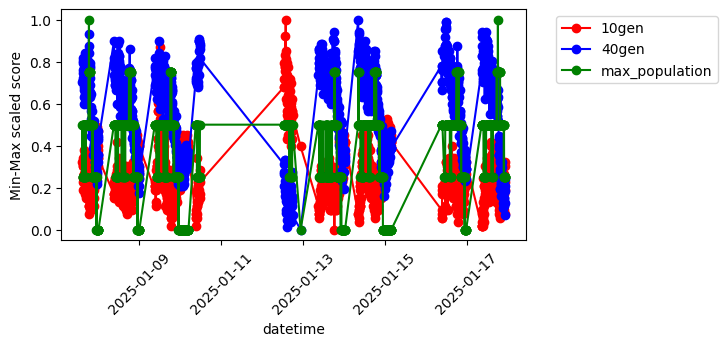

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
gen_col = ['10gen','40gen', 'max_population']
df_scaled = pd.DataFrame(scaler.fit_transform(df_target[gen_col]), columns = gen_col)
clr_col = ['r', 'b', 'g']

plt.figure(figsize=(6,3))
for g, c in zip(gen_col, clr_col):
    plt.plot(df_target.index, df_scaled[g], c=c, marker='o', label=g)
plt.xticks(rotation=45)
plt.xlabel('datetime')
plt.ylabel('Min-Max scaled score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

__3.1 인구와 10대, 40대__
* 상관계수: 인구-40대(0.81), 인구-10대(-0.77)
* 40대는 인구 변화와 유사한 변동성을 보임 -> 일과시간 기준으로 상승 및 하락이 반복
  - __따라서, 삼각지는 40대들이 일과 시간에는 관심이 있지만, 일과 이후에는 관심이 없는 그 무언가가 있음(직장이라던가 직장이라던가)__
* 10대는 인구 수가 감소할 때 오히려 증가함
  - __단, 타 세대와 비교하였을 때, 모든 기간에서 5%내외 였던 점을 근거로 해당지역에서 집계된 10대는 해당지역의 거주민일 경우도 배제할 수 없음__

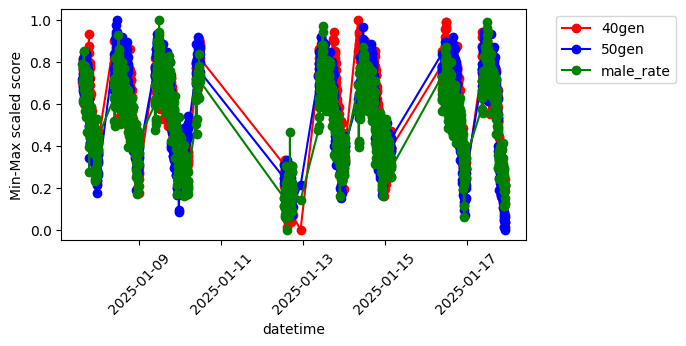

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
gen_col = ['40gen','50gen', 'male_rate']
df_scaled = pd.DataFrame(scaler.fit_transform(df_target[gen_col]), columns = gen_col)
clr_col = ['r', 'b', 'g', 'k']

plt.figure(figsize=(6,3))
for g, c in zip(gen_col, clr_col):
    plt.plot(df_target.index, df_scaled[g], c=c, marker='o', label=g)
plt.xticks(rotation=45)
plt.xlabel('datetime')
plt.ylabel('Min-Max scaled score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

__3.2 남성과 40-50대__
* 남성 비율 변화와 4050의 비율 변화는 매우 상관성이 높게 나타남(0.78, 0.84)
* 역시, 그 인구 수 패턴이 일과시간에 높고 출퇴근시 감소함

__현재까지 분석결과 종합 1__
* 삼각지는 40,50대 남성이 일과시간에 사람이 많고, 퇴근 시간을 기점으로 감소한다.
  - __특히 40대 남성은 총 인구수와도 높은 상관성을 나타낸다.__
  - __따라서 일과 시간 이후 총 인구수의 감소는 4050남성의 감소에 의해 발생하는 것으로 예상된다.__

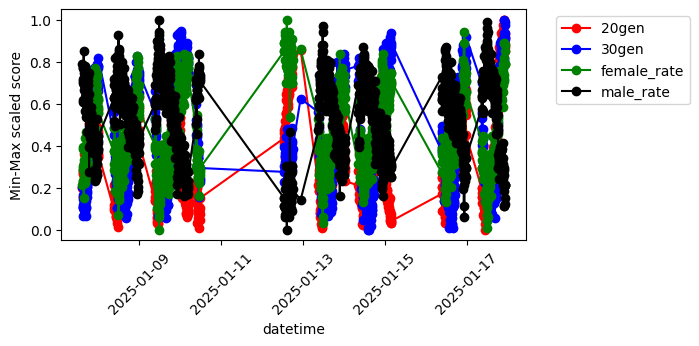

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
gen_col = ['20gen','30gen', 'female_rate', 'male_rate']
df_scaled = pd.DataFrame(scaler.fit_transform(df_target[gen_col]), columns = gen_col)
clr_col = ['r', 'b', 'g', 'k']

plt.figure(figsize=(6,3))
for g, c in zip(gen_col, clr_col):
    plt.plot(df_target.index, df_scaled[g], c=c, marker='o', label=g)
plt.xticks(rotation=45)
plt.xlabel('datetime')
plt.ylabel('Min-Max scaled score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

__3.2 20,30대의 성별에 따른 변화__
* 20,30대는 일과 이후 인구수에서 큰 비율을 차지하고 있는 세대 그룹이다. 따라서, 일과 이후 시간의 역 내 광고는 이들을 대상으로 진행하는 것이 효과적일 수 있다.
* 30대는 모든 기간에서 가장 높은 비율을 나타낸다. 특히 일과 시간 이후 증가한다는 점이 특히사항이며, 이는 여성과 유사하다.
* 또한, 20대는 일과 이후 증가하며, 이는 여성 비율 변화와 유사하다. 그러나, 심야 시간에는 오히려 남성과 유사한 변동성을 나타낸다.
* __본 보고서는 일과시간 이후 2030 여성의 증가 원인을 아래 두 개로 판단하였다.__
  - __Case 1: 놀러온 사람__ -> __주로 20대__
     - 근거: 일과시간 이후에 비율이 증가하지만 유지하지 못하고 지하철 막차 시간(23:00 정도)부터 급격히 낮아짐(통금....)
     - 심야시간에 집계된 20대들은 주로 삼각지 거주민일 것으로 예상됨 
  - __Case 2: 집이 삼각지인 사람__ -> __주로 30대__
     - 근거: 일과시간 이후 증가한 비율이 심야에 유지됨
     - 증가 이후 출근 전까지 비율이 유지됨
     - 또한, 해당 시간대의 여성 남성의 비율은 거의 50% 수준

### __결론: 삼각지역 광고 전략__
* 일과시간: 40,50대 남성들 위주로 공략
  - 캠핑용품, 등산화, 낚시 용품
* 일과시간 이후: 20,30대 위주로 공략 (해당 시간부터는 여성과 남성 비율이 동등해지기 시작하므로, 특정 성별에 고정하는것은 무의미하다고 판단)
  - 20대: 놀러온 사람이 대부분이므로, 숙취해소제 or 저가형 화장품(올리브영 같은거, 여성 타겟의 경우)
  - 30대: 식자재 마트

### __conclusion & discussion__
* 본 보고서는 삼각지 대상으로 통계분석을 하고 광고 전략을 간략하게 수립하였음
* 세대, 성별 별로 분석하여 광고 전략을 수립하는 것은 가능성이 있는것으로 판단되지만 이후 아래의 문제점을 해결할 필요가 있음
  - __타 지역 분석에 자동으로 적용하고 결과를 도출할 수 있는 프레임워크가 필요__
    - 이 후 최종 개발하고자 하는 프로젝트의 광고 목록(dummy로 만든거)가 확정 됬을 때, 지표화할 수 있는 방법론 개발 예정
* __대상 지역 주변의 상권 및 지역적 특성은 광고 선정에 중요한 지표가 될 수 있음. 시스템의 prototype 개발 후 개선 작업 시작 시 최초로 고려해야될 사항이라고 판단됨__  